## Part 1 - Article Sentiment information extraction 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.svm import SVR
import re
import csv 
import nltk
import warnings
import yfinance as yf
import xgboost as xgb
warnings.filterwarnings('ignore')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import trainer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ball4308/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
dfv = pd.read_csv("df_transed_cleaned.csv").drop(columns = ['Unnamed: 0'])
dfv['publish_date'] = pd.to_datetime(dfv['publish_date'])
dfv['date'] = dfv['publish_date'].apply(lambda x: x.date())
dfv = dfv.drop(columns =['translateda_mix','translateda_headline','translateda_headline_cleaned',
                         'translateda_mix_dic','translateda_headline_dic'])
dfv = dfv.rename(columns = {'translateda_mix_cleaned':'transated_mix_cleaned'})                    
dfv.head()

,stories_id,publish_date,title,url,language,ap_syndicated,themes,media_id,media_name,media_url,scraped_article,title_FB_only,BOG,date,transated_mix_cleaned
0,865782065,2015-01-03 18:12:00,"Ethan Ralph on Twitter: ""#GamerGate Ultras ove...",https://twitter.com/TheRalphRetort/status/5515...,en,False,NaN,18346,Twitter,http://twitter.com,"Ethan Ralph on Twitter: ""#GamerGate Ultras ove...",NaN,NaN,2015-01-03,ralph twitter appreciate big help
1,335784736,2015-01-07 07:23:39,The Daily Rupert on Twitter: &quot;Facebook v...,https://twitter.com/TheMurdochTimes/status/552...,en,False,NaN,18346,Twitter,http://twitter.com,The Daily Rupert on Twitter: &quot;Facebook v...,NaN,NaN,2015-01-07,daily twitter video image terrorist outside of...
2,335817091,2015-01-07 12:32:58,teleSUR TV on Twitter: &quot;El Festival de Ca...,https://twitter.com/teleSURtv/status/552880585...,en,False,NaN,18346,Twitter,http://twitter.com,teleSUR TV on Twitter: &quot;El Festival de Ca...,NaN,NaN,2015-01-07,twitter festival de en en
3,320258910,2015-01-15 21:39:09,Stop Patriarchy on Twitter: &quot;Tune in to n...,https://twitter.com/StopPatriarchy/status/5559...,en,False,NaN,18346,Twitter,http://twitter.com,Stop Patriarchy on Twitter: &quot;Tune in to n...,NaN,NaN,2015-01-15,stop patriarchy twitter join event
4,372077690,2015-01-24 07:00:00,Blocker (Mr. Fart) on Twitter: &quot;#GamerGat...,https://archive.is/ArtrI,en,False,computers and the internet,18346,Twitter,http://twitter.com,Blocker (Mr. Fart) on Twitter: &quot;#GamerGat...,NaN,NaN,2015-01-24,blocker twitter kop could not keep mouth shut ...


In [6]:
dfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7732 entries, 0 to 7731
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   stories_id             7732 non-null   int64         
 1   publish_date           7729 non-null   datetime64[ns]
 2   title                  7732 non-null   object        
 3   url                    7732 non-null   object        
 4   language               7716 non-null   object        
 5   ap_syndicated          7732 non-null   bool          
 6   themes                 1478 non-null   object        
 7   media_id               7732 non-null   int64         
 8   media_name             7732 non-null   object        
 9   media_url              7732 non-null   object        
 10  scraped_article        7732 non-null   object        
 11  title_FB_only          3928 non-null   object        
 12  BOG                    3928 non-null   object        
 13  dat

### Thanks for Jason: 
### We can use the lexicon based sentiment analyser to convert the clenaed article into 

In [8]:
# # stock market lexicon
stock_lex = pd.read_csv("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/stock_lex.csv")
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
     if v > 0:
         stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
     else:
         stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

### We used the Loughran and McDonald lexicon to represent the words represent positive and negative sentiment in the stock market 

In [10]:
### Loughran and McDonald
positive = []
with open("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/lm_positive.csv", 'r') as f:
     reader = csv.reader(f)
     for row in reader:
         positive.append(row[0].strip())
    
negative = []
with open("/Users/ball4308/Desktop/MSc BA/BA Report /Jason's Project _ Basic Demo /StockSentimentTrading-master/lexicon_data/lm_negative.csv", 'r') as f:
     reader = csv.reader(f)
     for row in reader:
         entry = row[0].strip().split(" ")
         if len(entry) > 1:
             negative.extend(entry)
         else:
             negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

In [12]:
dfv['transated_mix_cleaned'] = dfv['transated_mix_cleaned'].astype(str)
dfv['article_sentiment'] =  dfv['transated_mix_cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [14]:
senti_score = dfv.groupby('date')[['article_sentiment']].sum()
senti_score.head()

,article_sentiment
date,
2015-01-03,0.8320
2015-01-07,-0.4392
2015-01-15,0.1662
2015-01-24,0.0579
2015-02-05,0.3473


In [16]:
senti_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1489 entries, 2015-01-03 to 2020-08-07
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   article_sentiment  1489 non-null   float64
dtypes: float64(1)
memory usage: 23.3+ KB


In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = list(senti_score.index), y = senti_score['article_sentiment'],
                    mode='lines',
                    name='sarticle sentiment'))

fig.show()

In [20]:
finance = pd.read_csv('financial_wiki_2017_07_08.csv')
finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282 entries, 0 to 1281
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     1282 non-null   object 
 1   Facebook.wiki            1282 non-null   float64
 2   Google.wiki              1282 non-null   float64
 3   Microsoft.wiki           1282 non-null   float64
 4   Apple Inc..wiki          1282 non-null   float64
 5   AAPL                     1282 non-null   float64
 6   AMZN                     1282 non-null   float64
 7   FB                       1282 non-null   float64
 8   GOOGL                    1282 non-null   float64
 9   MSFT                     1282 non-null   float64
 10  FB_return                1282 non-null   float64
 11  GOOGL_return             1282 non-null   float64
 12  MSFT_return              1282 non-null   float64
 13  AMZN_return              1282 non-null   float64
 14  AAPL_return             

In [22]:
finance.head()

,Date,Facebook.wiki,Google.wiki,Microsoft.wiki,Apple Inc..wiki,AAPL,AMZN,FB,GOOGL,MSFT,...,Facebook.wiki_t-3_t-4,Google.wiki_t-1_t-2,Google.wiki_t-2_t-3,Google.wiki_t-3_t-4,Microsoft.wiki_t-1_t-2,Microsoft.wiki_t-2_t-3,Microsoft.wiki_t-3_t-4,Apple Inc..wiki_t-1_t-2,Apple Inc..wiki_t-2_t-3,Apple Inc..wiki_t-3_t-4
0,2015-07-08,10.723355,10.725951,9.256556,9.585690,28.189571,429.700012,85.650002,541.700012,39.941715,...,0.669849,0.024664,-0.024287,-0.016310,0.003597,-0.023742,0.025345,0.142520,-0.040248,0.054003
1,2015-07-09,10.762213,10.675816,9.190852,9.527047,27.614601,434.390015,85.879997,544.650024,40.194511,...,-0.746695,-0.046652,0.024664,-0.024287,0.331367,0.003597,-0.023742,0.074801,0.142520,-0.040248
2,2015-07-10,10.749849,10.660853,8.964056,9.425048,28.352858,443.510010,87.949997,556.109985,40.275764,...,-0.022031,-0.050135,-0.046652,0.024664,-0.065704,0.331367,0.003597,-0.058643,0.074801,0.142520
3,2015-07-13,10.759264,10.701850,8.969287,9.431883,28.900230,455.570007,90.099998,571.729980,41.115414,...,-0.011409,-0.014963,-0.050135,-0.046652,-0.226796,-0.065704,0.331367,-0.101999,-0.058643,0.074801
4,2015-07-14,10.703447,10.720400,8.897682,9.345570,28.888727,465.570007,89.680000,584.179993,41.187630,...,0.038857,0.040997,-0.014963,-0.050135,0.005231,-0.226796,-0.065704,0.006834,-0.101999,-0.058643


In [24]:
wiki_f = ['Facebook.wiki','Google.wiki','Microsoft.wiki','Apple Inc..wiki']
stock_f = ['AAPL','AMZN','FB','GOOGL','MSFT']
stock_f_r = [x + '_return' for x in stock_f if x != 'FB']
finance_c = finance.drop(columns = wiki_f + stock_f + stock_f_r )
finance_c.head()

,Date,FB_return,Facebook.wiki_t-1,Facebook.wiki_t-2,Facebook.wiki_t-3,Google.wiki_t-1,Google.wiki_t-2,Google.wiki_t-3,Microsoft.wiki_t-1,Microsoft.wiki_t-2,...,Facebook.wiki_t-3_t-4,Google.wiki_t-1_t-2,Google.wiki_t-2_t-3,Google.wiki_t-3_t-4,Microsoft.wiki_t-1_t-2,Microsoft.wiki_t-2_t-3,Microsoft.wiki_t-3_t-4,Apple Inc..wiki_t-1_t-2,Apple Inc..wiki_t-2_t-3,Apple Inc..wiki_t-3_t-4
0,2015-07-08,-0.018000,10.734765,10.756796,11.503491,10.772603,10.747939,10.772225,8.925188,8.921591,...,0.669849,0.024664,-0.024287,-0.016310,0.003597,-0.023742,0.025345,0.142520,-0.040248,0.054003
1,2015-07-09,0.002685,10.723355,10.734765,10.756796,10.725951,10.772603,10.747939,9.256556,8.925188,...,-0.746695,-0.046652,0.024664,-0.024287,0.331367,0.003597,-0.023742,0.074801,0.142520,-0.040248
2,2015-07-10,0.024103,10.762213,10.723355,10.734765,10.675816,10.725951,10.772603,9.190852,9.256556,...,-0.022031,-0.050135,-0.046652,0.024664,-0.065704,0.331367,0.003597,-0.058643,0.074801,0.142520
3,2015-07-13,0.024446,10.749849,10.762213,10.723355,10.660853,10.675816,10.725951,8.964056,9.190852,...,-0.011409,-0.014963,-0.050135,-0.046652,-0.226796,-0.065704,0.331367,-0.101999,-0.058643,0.074801
4,2015-07-14,-0.004661,10.759264,10.749849,10.762213,10.701850,10.660853,10.675816,8.969287,8.964056,...,0.038857,0.040997,-0.014963,-0.050135,0.005231,-0.226796,-0.065704,0.006834,-0.101999,-0.058643


In [26]:
finance_c = finance_c.set_index('Date')
finance_c.info()

KeyError: "None of ['Date'] are in the columns"

In [ ]:
 senti_score.index = pd.to_datetime(senti_score.index)

In [15]:
finance_c.index = pd.to_datetime(finance_c.index)

In [16]:
data = finance_c.merge(senti_score, left_index = True, right_index = True, how = 'left')
data = data.fillna(0)

In [17]:
print(data.shape)

(1282, 41)


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1282 entries, 2015-07-08 to 2020-08-07
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FB_return                1282 non-null   float64
 1   Facebook.wiki_t-1        1282 non-null   float64
 2   Facebook.wiki_t-2        1282 non-null   float64
 3   Facebook.wiki_t-3        1282 non-null   float64
 4   Google.wiki_t-1          1282 non-null   float64
 5   Google.wiki_t-2          1282 non-null   float64
 6   Google.wiki_t-3          1282 non-null   float64
 7   Microsoft.wiki_t-1       1282 non-null   float64
 8   Microsoft.wiki_t-2       1282 non-null   float64
 9   Microsoft.wiki_t-3       1282 non-null   float64
 10  Apple Inc..wiki_t-1      1282 non-null   float64
 11  Apple Inc..wiki_t-2      1282 non-null   float64
 12  Apple Inc..wiki_t-3      1282 non-null   float64
 13  FB_return_t-1            1282 non-null   float64
 14  FB_ret

## Part 2 - Modelling & Parameter tunning

In [19]:
def MAPE(true, pred): 

    y_true, y_pred = np.array(true), np.array(pred)

    return round(abs((y_true- y_pred)/y_true).mean() * 100,4)

* Train-test split 

In [20]:
train_test_split = 0.80
total_days = len(data.index)
split_week = data.index[round(total_days*(train_test_split))]
train = data[data.index <= split_week]
test = data[data.index > split_week]
print(split_week)
print(train.shape)
print(test.shape)

2019-08-05 00:00:00
(1027, 41)
(255, 41)


In [21]:
from sklearn.preprocessing import StandardScaler
x_sc = StandardScaler()
y_sc = StandardScaler()

In [22]:
train_X, train_y = train.drop(columns = ['FB_return']), train['FB_return']

In [23]:
test_X, test_y = test.drop(columns = ['FB_return']), test['FB_return']

In [24]:
train_X_sc, train_y_sc = x_sc.fit_transform(train_X), y_sc.fit_transform(train_y.values.reshape(-1, 1))
test_X_sc, test_y_sc = x_sc.transform(test_X), y_sc.transform(test_y.values.reshape(-1, 1))

In [25]:
print(train_X_sc.shape, train_y_sc.shape)
print(test_X_sc.shape, test_y_sc.shape)

(1027, 40) (1027, 1)
(255, 40) (255, 1)


* Define time-series split to performe time series cross validation 

### Here we start a step-by-step demo of using LGBM first and then package every thing into trainer.py to compare performance of several models 

In [26]:
time_split = TimeSeriesSplit(n_splits=5)
reg1 = lgb.LGBMRegressor()

In [27]:
grid = {'num_leaves': [int(x) for x in np.logspace(start = 3, stop = 5 , num=5, base = 2)], 
        'learning_rate': np.linspace(0.05,0.5,5)}
RCV = GridSearchCV(estimator=reg1 , 
                   param_grid= grid, 
                   scoring='neg_mean_squared_error', 
                   n_jobs=-1, 
                   cv=time_split, 
                   verbose=50)
RCV.fit(train_X_sc,train_y_sc)              

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.05  , 0.1625, 0.275 , 0.3875, 0.5   ]),
                         'num_leaves': [8, 11, 16, 22, 32]},
             scoring='neg_mean_squared_error', verbose=50)

In [28]:
RCV.best_estimator_

LGBMRegressor(learning_rate=0.05, num_leaves=8)

In [29]:
RCV.best_score_

-1.042775750042102

## Training performance evaluation

In [30]:
temp = yf.download('FB', start='2015-07-07', end='2015-07-09')['Adj Close']
temp

[*********************100%***********************]  1 of 1 completed


Date
2015-07-06    87.550003
2015-07-07    87.220001
2015-07-08    85.650002
Name: Adj Close, dtype: float64

In [31]:
lis = [temp['2015-07-07']] + list(finance[finance['Date'] >= '2015-07-08'][finance['Date'] <= '2019-08-02']['FB'])
print(len(lis))

1027


In [32]:
fb_t_1_tr = pd.Series(lis)
fb_true_tr = finance[finance['Date'] >= '2015-07-08'][finance['Date'] <= '2019-08-05']['FB']

In [33]:
yhat_return_sc_tr = RCV.best_estimator_.predict(train_X_sc)
yhat_return_tr =  y_sc.inverse_transform(yhat_return_sc_tr) 
yhat_stock_tr = (yhat_return_tr + 1) * fb_t_1_tr
print('mean squared error {}'.format(mean_squared_error(fb_true_tr, yhat_stock_tr))) 
print('mean absolute error {}'.format(mean_absolute_error(fb_true_tr, yhat_stock_tr))) 
print('mean absolute percentage error(%) {}'.format(MAPE(fb_true_tr, yhat_stock_tr)))

mean squared error 4.593085245056988
mean absolute error 1.407153304283158
mean absolute percentage error(%) 0.9712


## Prediction performance evaluation 

In [34]:
fb_t_1 = finance[finance['Date'] >= '2019-08-05'][finance['Date'] <= '2020-08-06']['FB']
fb_true = finance[finance['Date'] >= '2019-08-06'][finance['Date'] <= '2020-08-07']['FB']

In [35]:
yhat_return_sc = RCV.best_estimator_.predict(test_X_sc)
yhat_return =  y_sc.inverse_transform(yhat_return_sc) 
yhat_stock = (yhat_return + 1) * fb_t_1
print('mean squared error {}'.format(mean_squared_error(fb_true, yhat_stock))) 
print('mean absolute error {}'.format(mean_absolute_error(fb_true, yhat_stock))) 
print('mean absolute percentage error(%) {}'.format(MAPE(fb_true, yhat_stock)))

mean squared error 25.18069043668389
mean absolute error 3.4455862460749946
mean absolute percentage error(%) 1.7675


In [36]:
yhat_stock.index = test.index
fb_true.index = test.index

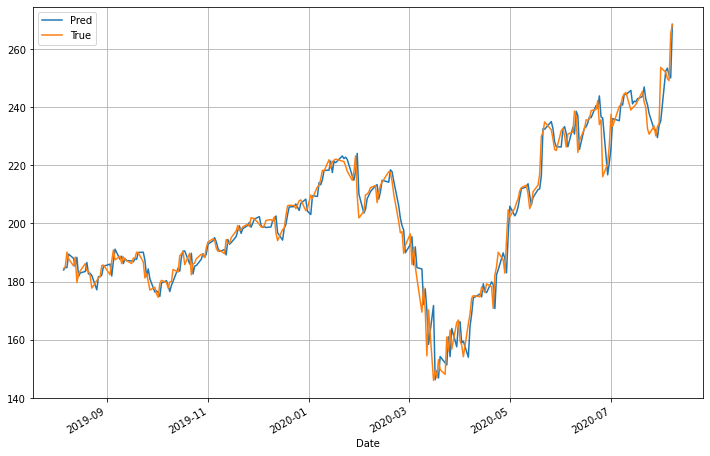

In [37]:
plt.figure(figsize=(12, 8))
yhat_stock.plot(label = 'Pred')
fb_true.plot(label = 'True')
plt.legend()
plt.grid()

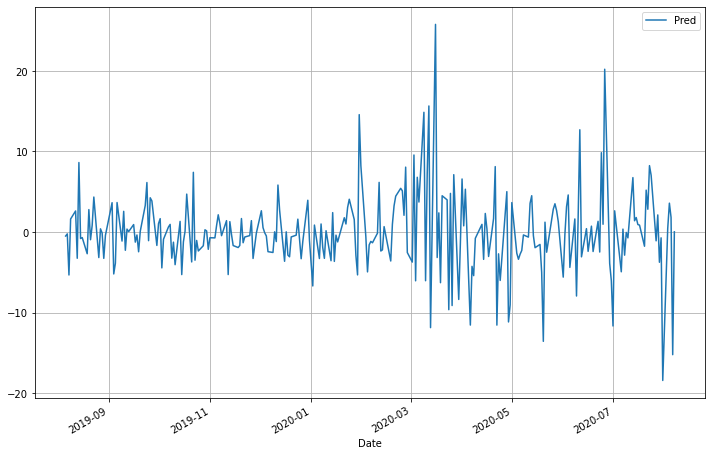

In [38]:
plt.figure(figsize=(12, 8))
(yhat_stock - fb_true).plot(label = 'Pred')
plt.legend()
plt.grid()

## Evaluation with XG boosting 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   

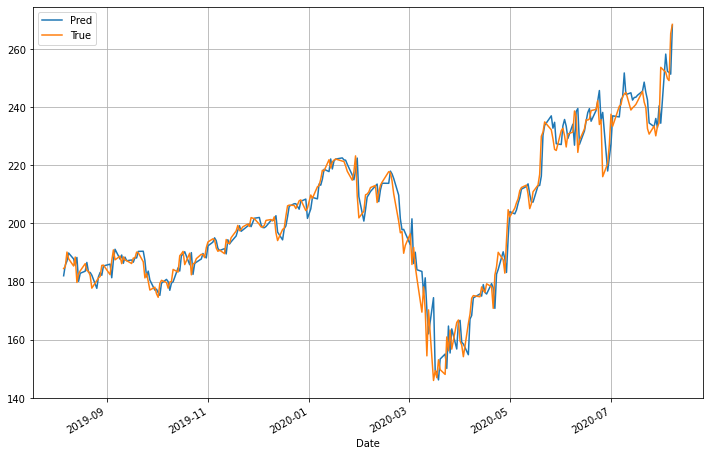

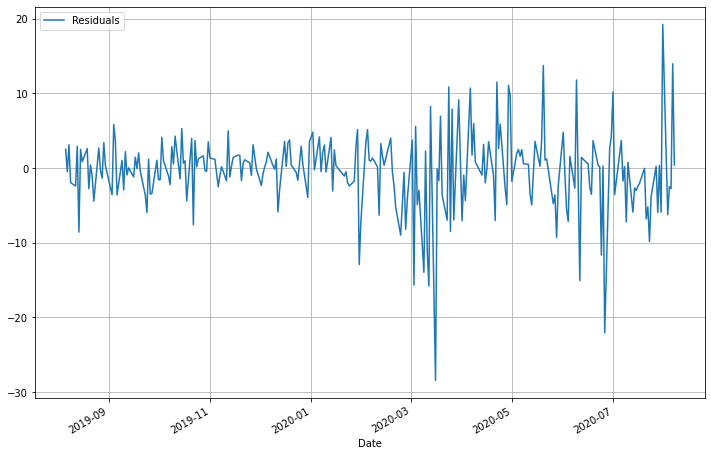

In [42]:
reg = xgb.XGBRegressor()
grid = {'num_leaves': [int(x) for x in np.logspace(start = 3, stop = 5 , num=5, base = 2)], 
        'learning_rate': np.linspace(0.05,0.5,5)}
yhat_stock_2, fb_true_2, xgboost = trainer.train_test_perfornace(reg, grid, finance, train_X_sc, train_y_sc, test_X_sc, test_y_sc, 
                          train, test, y_sc, time_split)

##  Part 3 - Reflection 

0. We have observed seriour overfitting for our model, although we only have 8 leaves in our decision trees. Considering using discriminative models, i.e. SVR or much simplier Lasso / Ridge Regression to compare 

1. For both XG bossting and LGBM, we have observed higher residuals when the time moves beyond 2020 February, indicating that the predictors provided are losing predictive power. This is intuitive, since Stock price is affected by wide range of factors, what used to before may not consistently work well in the future. We recommend to use these features as a 5 month forecasting model, instead of a full-year one 

2. Although XG boosting does not performe as well as LGBM on aggregate, we have observed that XG Boosting performs better than LGBM before 2020 February, as shown below the differnce is obvious

In [47]:
xg_mse = mean_squared_error(yhat_stock_2[yhat_stock_2.index <= '2020-02-01'], fb_true_2[fb_true_2.index <= '2020-02-01'])
print(xg_mse)

8.914014134402091


In [48]:
lgbm_mse = mean_squared_error(yhat_stock[yhat_stock.index <= '2020-02-01'], fb_true[fb_true.index <= '2020-02-01'])
print(lgbm_mse)

9.721589679164227


3. Visulalise the feature importance to understand which factors are important 

In [73]:
RCV.best_estimator_.fit(train_X_sc, train_y_sc)

LGBMRegressor(learning_rate=0.05, num_leaves=8)

In [74]:
importance_value = RCV.best_estimator_.feature_importances_
importance_name = train_X.columns

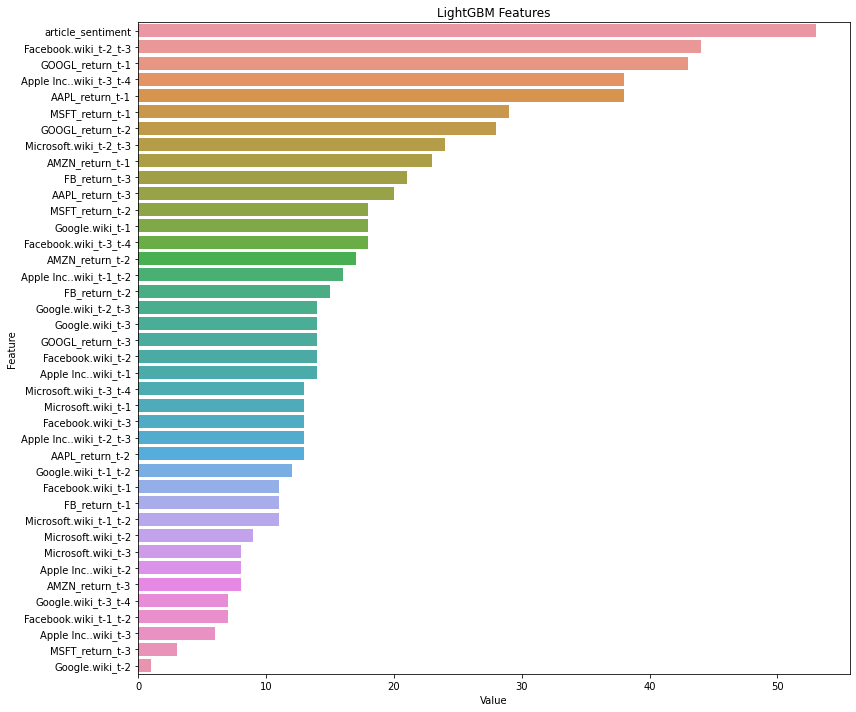

In [75]:
feature_imp = pd.DataFrame(sorted(zip(importance_value , importance_name)), columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [76]:
xgboost.best_estimator_.fit(train_X_sc, train_y_sc)
importance_value = xgboost.best_estimator_.feature_importances_
importance_name = train_X.columns

[13:22:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


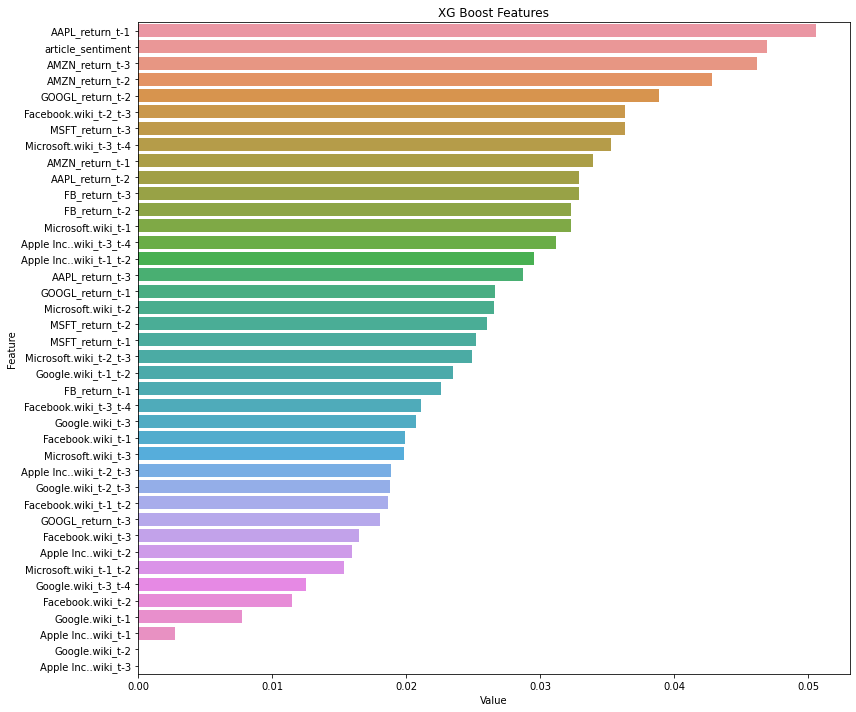

In [77]:
feature_imp = pd.DataFrame(sorted(zip(importance_value , importance_name)), columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XG Boost Features')
plt.tight_layout()
plt.show()

* We have found that: 

(1) both models show that article sentiment score by Vader has strong predicitve power 

(2) Financial return has a stronger predictive power than Wikipedia page view on average (more appearance in the upper part of the graph)

(3) The differnce between t-2 and t-3 days' Wikipedia Page view of other companies (i.e. Microsoft / Apple) tend to have much stronger predictive powet than other wikipedia predictors 